# IMPORTING LIBRARIES

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import time
t = time.time()

print('Importing startred...')

# base libraries
import os
import numpy as np
import pandas as pd
import re
from scipy import stats
from random import randint
from datetime import datetime


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px

# preprocessing libraries
from sklearn.model_selection import (TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                    cross_val_score)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   OrdinalEncoder)
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error)
from sklearn.metrics import make_scorer


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso, 
                                  ridge_regression,
                                  LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, 
                              RandomForestRegressor,
                              VotingRegressor, 
                              GradientBoostingRegressor)
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import (LGBMRegressor,
                      early_stopping)

from sklearn.base import clone ## sklearn base models for stacked ensemble model
from sklearn.pipeline import make_pipeline


print('Done, All the required modules are imported. Time elapsed: {}sec'.format(time.time()-t))

Importing startred...


Done, All the required modules are imported. Time elapsed: 3.0690808296203613sec


first model prediction then timeseries forecasting


#  GETTING TO KNOW MORE ABOUT THE DATA

In [2]:
# importing data
data = pd.read_csv('../input/walmart-dataset/Walmart.csv', parse_dates=['Date'] )#, index_col = ['Store'])
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
data.shape

(6435, 8)

In [4]:
data.describe()#result is numeric because there are no categorial columns

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [5]:
# FINDING UNIQUE VALUE FOR CATEGORIAL COLUMNS
for i in ['Store','Fuel_Price','Unemployment']:#,'Day','Month','Year']:
    print(f'{i}: {data[i].nunique()}')

Store: 45
Fuel_Price: 892
Unemployment: 349


In [6]:
# GETTING THE DATA TYPES+
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


# EXPLORATORY DATA ANALYSIS(EDA)


In [7]:
fig = px.histogram(data, x='Temperature', y ='Weekly_Sales', color='Holiday_Flag')#,color = "red")#, marginal='box')
fig.show()
# corelating the tempratue and weeklu sales

In [8]:
fig = px.histogram(data, x='Unemployment', y ='Weekly_Sales')#, color = "red" )--> should bename of columns only

fig.show()


In [9]:
fig = px.histogram(data, x='Unemployment', y ='Weekly_Sales', marginal='box', title = 'How Unemployment affect sales', template='simple_white')
fig.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

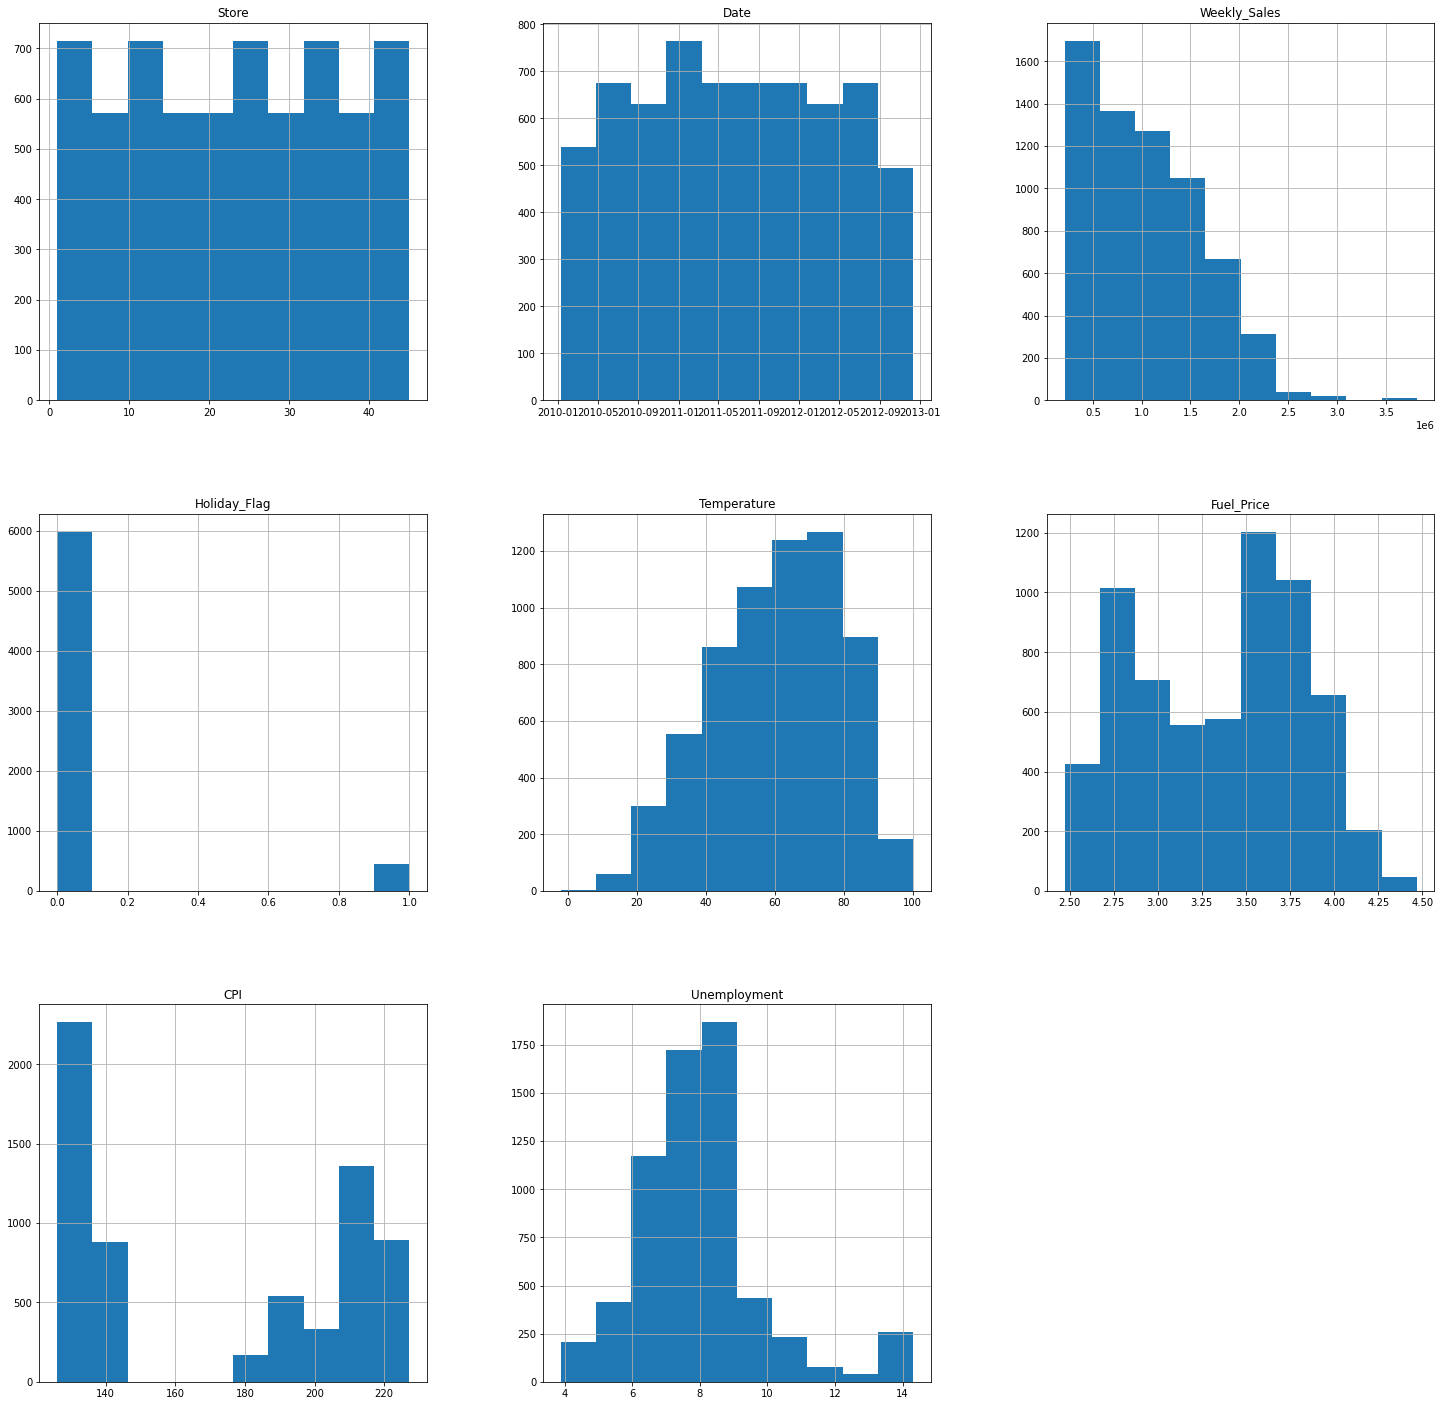

In [10]:
fig = plt.figure(figsize=(25,25))
ax = fig.gca()
data.hist(ax=ax)
plt.tight_layout

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

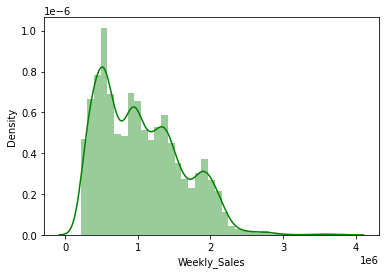

In [11]:
sns.distplot(data['Weekly_Sales'],kde=True, color="g")#, ax=axes[0, 0])

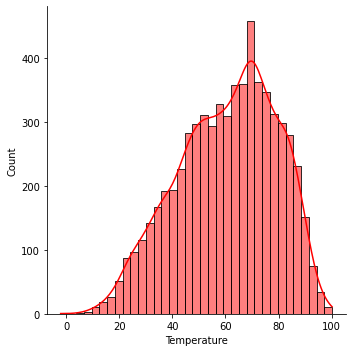

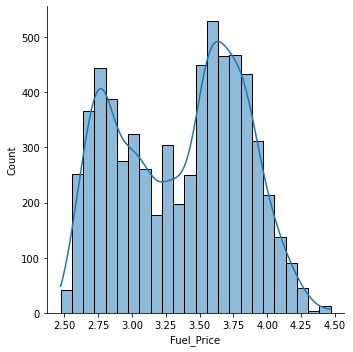

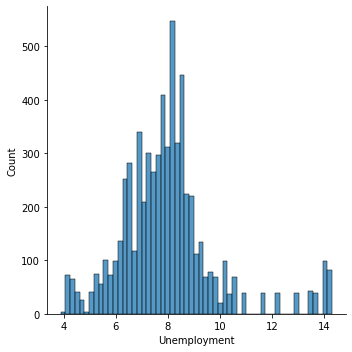

In [12]:
sns.displot(data['Temperature'],kde=True,color = 'r')#, ax=axes[1])
sns.displot(data['Fuel_Price'],kde=True)
sns.displot(data['Unemployment'],kde=False)

# doing some analysis using TIMESERIES factor

**# converting days and months from numerics to categories**

In [13]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Day'] = data.Date.dt.day
data['WeekOfYear'] = data.Date.dt.isocalendar().week

In [14]:
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5: 'Friday',6:'Saturday'}
data['Day'] = data['Day'].map(days)
months={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'Novemenber',12:'December'}
data['Month']= data['Month'].map(months)
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,May,Tuesday,17
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,December,Tuesday,48
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,February,NaN,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,February,NaN,8
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,May,Wednesday,18


<AxesSubplot:xlabel='Year', ylabel='count'>

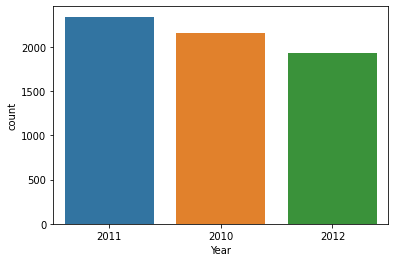

In [15]:
sns.countplot(data['Year'],order=data['Year'].value_counts().index)


<AxesSubplot:xlabel='Day', ylabel='count'>

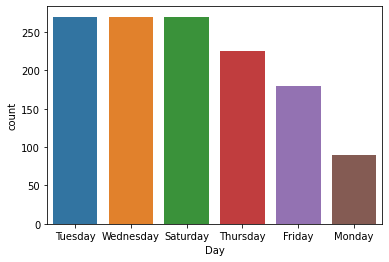

In [16]:
# plt.figure(figsize=(8,4))
sns.countplot(data['Day'],order=data['Day'].value_counts().index)

<AxesSubplot:xlabel='Month', ylabel='count'>

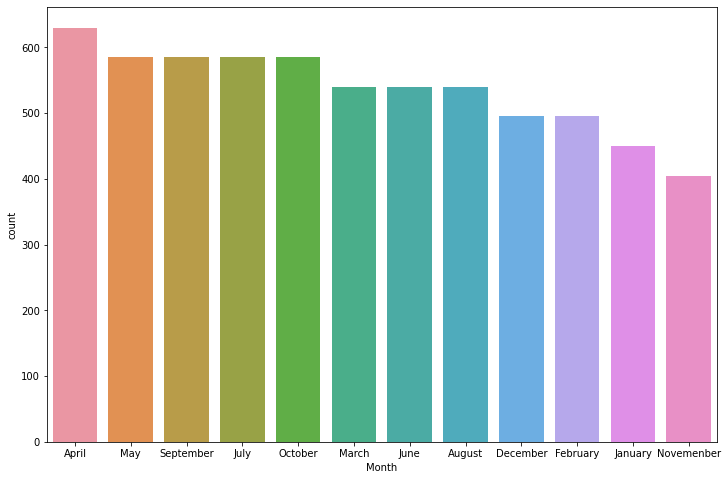

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(data['Month'],order= data['Month'].value_counts().index)

Text(0.5, 1.0, 'Annual Sales')

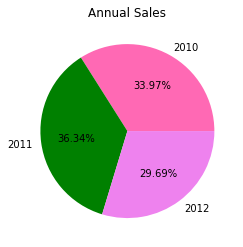

In [18]:
plt.pie(data.groupby('Year')['Weekly_Sales'].sum(),labels=data['Year'].unique(),normalize=True,autopct='%1.2f%%',colors=['hotpink','green','violet'])
plt.title('Annual Sales')

([<matplotlib.patches.Wedge at 0x7fe201873310>,
 [Text(0.9988167477806474, 0.4608308847645637, 'Friday'),
  Text(0.533180768931767, 0.9621425401889939, 'Monday'),
  Text(-0.38900665279284063, 1.0289187645693467, 'Saturday'),
  Text(-1.0999721498201867, -0.007827491293947317, 'Thursday'),
  Text(-0.38543913574872063, -1.030260487756994, 'Tuesday'),
  Text(0.8848335116254168, -0.6535056669261817, 'Wednesday')],
 [Text(0.5448091351530804, 0.25136230078067107, '13.76%'),
  Text(0.290825873962782, 0.5248050219212693, '6.37%'),
  Text(-0.21218544697791306, 0.5612284170378253, '21.24%'),
  Text(-0.599984808992829, -0.004269540705789445, '17.48%'),
  Text(-0.21023952859021122, -0.5619602660492694, '20.90%'),
  Text(0.4826364608865909, -0.35645763650518997, '20.25%')])

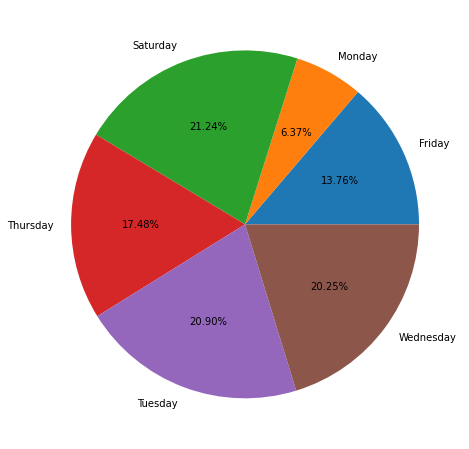

In [19]:
df2 = data.groupby('Day')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(10,8))
plt.pie(df2['Weekly_Sales'],labels= df2['Day'],autopct='%1.2f%%', normalize=True)

([<matplotlib.patches.Wedge at 0x7fe2017d4950>,
 [Text(1.0505715420703448, 0.3260359412579202, 'April'),
  Text(0.7135560893168025, 0.8371605027704733, 'August'),
  Text(0.17894470808660848, 1.0853473137423792, 'December'),
  Text(-0.38685422481986037, 1.0297299688457286, 'February'),
  Text(-0.7903461501230193, 0.7650836313670042, 'January'),
  Text(-1.0529134511925988, 0.3183916837759601, 'July'),
  Text(-1.0654902855032773, -0.27336870980078276, 'June'),
  Text(-0.7840328017971336, -0.7715520499008066, 'March'),
  Text(-0.2752227535923998, -1.0650128806286887, 'May'),
  Text(0.26538381737518074, -1.0675071098008562, 'Novemenber'),
  Text(0.7408373645676252, -0.8131174572351131, 'October'),
  Text(1.0585579767623141, -0.29909030380952856, 'September')],
 [Text(0.5730390229474608, 0.1778377861406837, '9.58%'),
  Text(0.3892124123546195, 0.4566330015111672, '8.37%'),
  Text(0.09760620441087733, 0.5920076256776613, '8.89%'),
  Text(-0.21101139535628746, 0.5616708920976701, '7.75%'),
  T

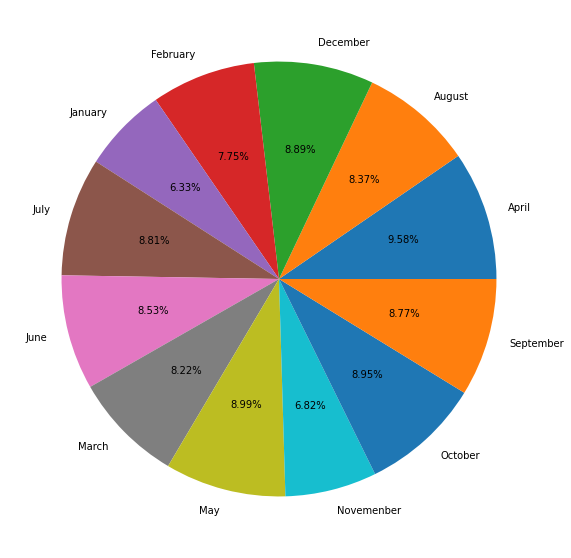

In [20]:
plt.figure(figsize=(10,10))
df3 = data.groupby('Month')['Weekly_Sales'].sum().reset_index()
plt.pie(df3['Weekly_Sales'],labels=df3['Month'],normalize=True,autopct='%1.2f%%')

([<matplotlib.patches.Wedge at 0x7fe201704290>,
 [Text(-0.25679386593526243, -1.0696059603508306, 'Non Special Holiday Week'),
  Text(0.3268284610531304, 1.361316699760068, 'Special Holiday Week')],
 [Text(-0.14006938141923403, -0.5834214329186348, '92.50%'),
  Text(0.2101040106770124, 0.8751321641314721, '7.50%')])

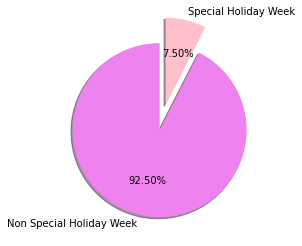

In [21]:
df4 = data.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()
plt.pie(df4['Weekly_Sales'],labels= ['Non Special Holiday Week','Special Holiday Week'],normalize=True,autopct='%1.2f%%',startangle=90,explode=[0,0.3],shadow=True,colors=['violet','pink'])

In [22]:
fig = px.histogram(data, x='WeekOfYear', y ='Weekly_Sales')
fig.show()
# a seasonal pattern can be analysied so we will dig deep into timeseries forecasting

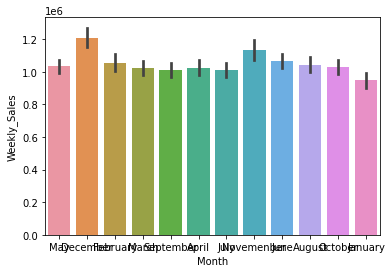

In [23]:
sns.barplot(data["Month"], data["Weekly_Sales"], )
plt.show()

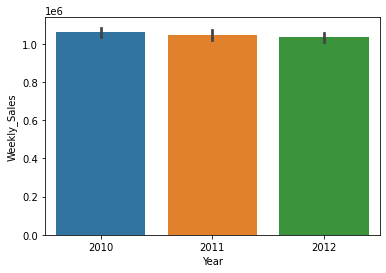

In [24]:
sns.barplot(data["Year"], data["Weekly_Sales"], )
plt.show()


# DATA PROCESSING FOR MODEL FIT

In [25]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

Text(0.5, 1.0, 'Correlation Matrix')

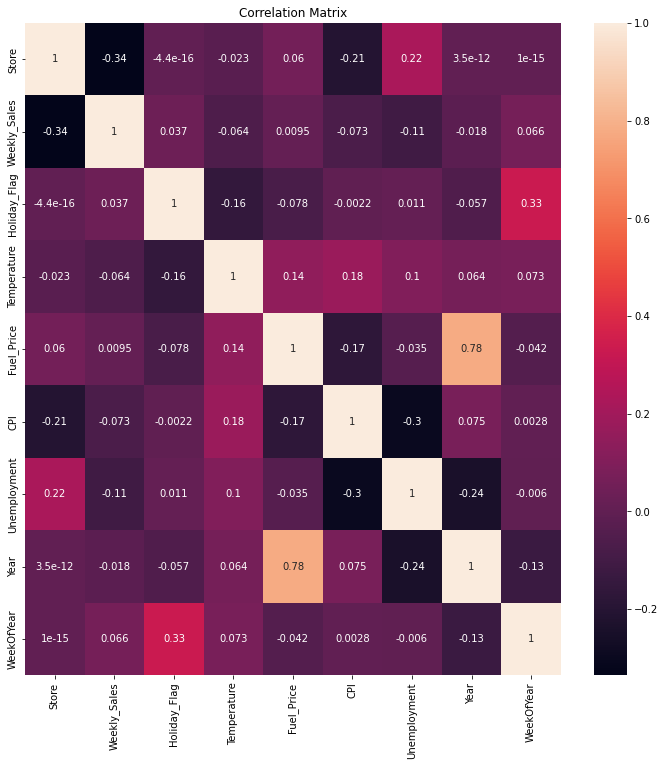

In [26]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),annot=True)
plt.title('Correlation Matrix')

In [27]:
X = data.drop(['Weekly_Sales' , 'Date'],axis=1)
Y = data['Weekly_Sales']

droping date column as timestap cnt be used to trai the models

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int64  
 7   Month         6435 non-null   object 
 8   Day           1305 non-null   object 
 9   WeekOfYear    6435 non-null   UInt32 
dtypes: UInt32(1), float64(4), int64(3), object(2)
memory usage: 484.0+ KB


**ENCODING OF DATA**

In [29]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
# final[['notes'] , ['time']] = encoder.fit_transform(final[['notes'] , ['time']])
col = ['Month' , 'Day']
X[col] = encoder.fit_transform(X[col])

# final = encoder.fit_transform(final)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int64  
 7   Month         6435 non-null   float64
 8   Day           1305 non-null   float64
 9   WeekOfYear    6435 non-null   UInt32 
dtypes: UInt32(1), float64(6), int64(3)
memory usage: 484.0 KB


**error was thrown for missing values**

In [30]:
X.fillna(X.median().round(1), inplace=True)

In [31]:
# TRAIN AND TEST SPLIT
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=42)

In [32]:
# ONE HOT ENCOING
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
transformer = ColumnTransformer(transformers=[('tf',OneHotEncoder(sparse=False,drop='first'),['Store'])],remainder='passthrough')
X_train= transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [33]:
# SCALING OF DATA FOR BETTER FITTING AND LES S TIME CONSUMPTION
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)
X_train = rob_scaler.transform(X_train)
X_test = rob_scaler.transform(X_test)

In [34]:
def pred_model(model,X_train,Y_train,X_test,Y_test):
    c = model()
    c.fit(X_train,Y_train)
    y_pred = c.predict(X_test)
    print(model)
    print(f'MSE: {mean_squared_error(Y_test,y_pred)}')
    print(f'MAE: {mean_absolute_error(Y_test,y_pred)}')
    print(f'R2 : {r2_score(Y_test,y_pred)}')

# USING VARIOUS INDIVISUAL REGRESSION MODELS

In [35]:
# USING Linear Regression MODEL
pred_model(LinearRegression,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._base.LinearRegression'>
MSE: 24366185223.042057
MAE: 98801.83585982991
R2 : 0.9233059676470355


In [36]:
# USING Lasso Regression MODEL
pred_model(Lasso,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._coordinate_descent.Lasso'>
MSE: 24375424585.855507
MAE: 98275.5557130057
R2 : 0.9232768861973113


In [37]:
# USING Ridge Regression MODEL
pred_model(Ridge,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._ridge.Ridge'>
MSE: 24726727209.548176
MAE: 98834.52067602551
R2 : 0.9221711400765895


In [38]:
# USING Random Forest Regressor MODEL
pred_model(RandomForestRegressor,X_train,Y_train,X_test,Y_test)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
MSE: 19656288245.30557
MAE: 73687.81506802645
R2 : 0.938130651440708


In [39]:
# USING ElasticNet MODEL
pred_model(ElasticNet,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
MSE: 288411693903.4598
MAE: 451390.3795674732
R2 : 0.09220686042032467


In [40]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)
# def cv_rmse(model, X = x_train):
#     rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
#     return rmse

# def rmsle(y, y_pred):
#     rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
#     return rmsle

In [41]:
# from sklearn.preprocessing import RobustScaler
# rob_scaler = RobustScaler()
# rob_scaler.fit(X_train)
# X_train = rob_scaler.transform(X_train)
# X_test = rob_scaler.transform(X_test)

In [42]:
import warnings
warnings.filterwarnings('ignore')


# USING VARIOUS STACKED VERSION OF REGRESSION MODELS

In [43]:
xgb = XGBRegressor(n_estimators = 1000, random_state = 1)
lgbm = LGBMRegressor(n_estimators = 1000, random_state = 1)
gbr = GradientBoostingRegressor(n_estimators = 1000, random_state = 11)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
svr = SVR(C = 20)
lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4,
                                                        5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
                                                        0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
                                                        45, 50, 70, 90], n_jobs = -1, cv = k_fold)

stacked = StackingCVRegressor(regressors = (xgb, lgbm, svr, lasso, gbr, rf),
                              meta_regressor = xgb, use_features_in_secondary = True)

In [44]:
stacked_model = stacked.fit(np.array(X_train), np.array(Y_train))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182730764624.64062, tolerance: 88657421070.06784
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1385707582969.1719, tolerance: 88657421070.06784
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2112590157172.8203, tolerance: 88657421070.06784
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440675583

Text(0, 0.5, 'prediction')

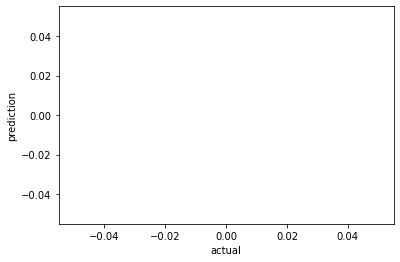

In [45]:
y_pred = np.expm1(stacked_model.predict(X_test))
y_pred[0:25]

plt.scatter(Y_test, y_pred);
plt.xlabel("actual")

plt.ylabel("prediction")

In [46]:
stacked_score_train = mean_squared_error(Y_train, stacked_model.predict(X_train))
print("mean_squared_error score of stacked models on full train data:", stacked_score_train)
#RMSLE score of the stacked model on full TEST data

stacked_score_test = mean_absolute_error(Y_test, stacked_model.predict(X_test))
print("mean_absolute_error score of stacked models on full test data:", stacked_score_test)

mean_squared_error score of stacked models on full train data: 2242035822.363901
mean_absolute_error score of stacked models on full test data: 51379.001815996504


In [47]:
X.shape

(6435, 10)

# NOW USING THE DEEP LEARNIG NETWORK FOR SAME PREDICTION 

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [X_train.shape[1]]
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(8 ,activation= 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(24, activation = 'relu'),
    layers.Dense(10 )
])    

    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X_train, Y_train,
#     validation_data=(X2_test, y2_test),
    validation_split= 0.2,
    batch_size=25,
    epochs=1000,
    callbacks=[early_stopping]
)

2022-09-22 01:13:45.750275: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-22 01:13:45.948778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
124/124 [==============================] - 2s 4ms/step - loss: 1396149190656.0000 - mean_squared_error: 1396149190656.0000 - val_loss: 1416124956672.0000 - val_mean_squared_error: 1416124956672.0000
Epoch 2/1000
124/124 [==============================] - 0s 2ms/step - loss: 1396134772736.0000 - mean_squared_error: 1396134772736.0000 - val_loss: 1416096120832.0000 - val_mean_squared_error: 1416096120832.0000
Epoch 3/1000
124/124 [==============================] - 0s 2ms/step - loss: 1396065304576.0000 - mean_squared_error: 1396065304576.0000 - val_loss: 1415952072704.0000 - val_mean_squared_error: 1415952072704.0000
Epoch 4/1000
124/124 [==============================] - 0s 2ms/step - loss: 1395856506880.0000 - mean_squared_error: 1395856637952.0000 - val_loss: 1415627014144.0000 - val_mean_squared_error: 1415627014144.0000
Epoch 5/1000
124/124 [==============================] - 0s 2ms/step - loss: 1395456475136.0000 - mean_squared_error: 1395456475136.0000 - val_loss: 1415

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31391552902170.406, tolerance: 88919445170.7439
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30549925236418.332, tolerance: 88919445170.7439
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31911665339214.6, tolerance: 88919445170.7439
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31646224274703

124/124 [==============================] - 0s 3ms/step - loss: 354901983232.0000 - mean_squared_error: 354901983232.0000 - val_loss: 279003987968.0000 - val_mean_squared_error: 279003987968.0000
Epoch 85/1000
  1/124 [..............................] - ETA: 0s - loss: 138566598656.0000 - mean_squared_error: 138566598656.0000

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28899196827605.453, tolerance: 87552275975.01733
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28900811252565.773, tolerance: 87552275975.01733
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28901209026919.17, tolerance: 87552275975.01733
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5415452726

124/124 [==============================] - 0s 2ms/step - loss: 340136198144.0000 - mean_squared_error: 340136198144.0000 - val_loss: 269846331392.0000 - val_mean_squared_error: 269846331392.0000
Epoch 86/1000
124/124 [==============================] - 0s 2ms/step - loss: 322874114048.0000 - mean_squared_error: 322874114048.0000 - val_loss: 252756246528.0000 - val_mean_squared_error: 252756246528.0000
Epoch 87/1000
124/124 [==============================] - 0s 2ms/step - loss: 307398803456.0000 - mean_squared_error: 307398803456.0000 - val_loss: 230282952704.0000 - val_mean_squared_error: 230282952704.0000
Epoch 88/1000
124/124 [==============================] - 0s 2ms/step - loss: 295012139008.0000 - mean_squared_error: 295012139008.0000 - val_loss: 214739730432.0000 - val_mean_squared_error: 214739730432.0000
Epoch 89/1000
124/124 [==============================] - 0s 2ms/step - loss: 279313055744.0000 - mean_squared_error: 279313055744.0000 - val_loss: 206291599360.0000 - val_mean_sq

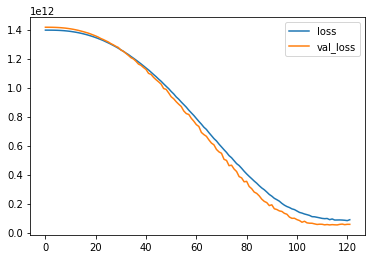

In [49]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [50]:
mse, mae = model.evaluate(X_test , Y_test)
print( "mean square error is :" , mse)
print( "mean abosulte error is :" , mae)

81/81 [==============================] - 0s 1ms/step - loss: 60531085312.0000 - mean_squared_error: 60531085312.0000
mean square error is : 60531085312.0
mean abosulte error is : 60531085312.0


# NOW WE CA EASILY COMPARE THE BEST WAY TO TRAIN OUR MODEL AND PREDICT A BETTER AND EFFICIENT RESULT